<a href="https://colab.research.google.com/github/mrpranti/Face/blob/main/Prediction_CompareTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Preparation of constants, paths, libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/DL Group Project
%ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1q1oh4KNPvyl3ACTsbffzNd5ALcMrB42e/DL Group Project
 Lecture_Notebooks/   Project_Code/  'Project Organization'/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch

In [ ]:
# select here which model you want to use
model_type = 'ResNet'
# model_type = 'Model03'
# model_type = 'MobileNet'

test_csv_path = 'Project_Code/Data/test.csv'

if model_type == 'ResNet':
  output_path = 'Project_Code/OutputFolder/ResNet'
elif model_type == 'Model03':
  output_path = 'Project_Code/OutputFolder/Model03'
elif model_type == 'MobileNet': # doesn't has its own folder yet
  output_path = 'Project_Code/OutputFolder/MobileNet'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Size of images
SIZE = 96

# 2) Prepare Model

In [ ]:
# load additional libraries 
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Residual Block from Dive Into Deep Learning 
# (http://d2l.ai/chapter_convolutional-modern/resnet.html)

class Residual(nn.Module):  
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = F.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)
        if self.conv3:
            X = self.conv3(X)
        Y += X

        return F.relu(Y)

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.conv = nn.Conv2d(1, 32, kernel_size=3, padding = 'same')
        self.pool = nn.MaxPool2d(2, 2)

        self.blk1 = Residual(32, 64, use_1x1conv=True, strides=2)
        self.blk2 = Residual(64, 128, use_1x1conv=True, strides=2)
        self.blk3 = Residual(128, 256, use_1x1conv=True, strides=2)
        self.blk4 = Residual(256, 512, use_1x1conv=True, strides=2)

        self.fc1 = nn.Linear(512, 256) 
        self.fc2 = nn.Linear(256,30)
    def forward(self, x):
         x = self.conv(x)
         x = self.pool(x)
         x = self.blk1(x)
         x = self.blk2(x)
         x = self.blk3(x)
         x = self.blk4(x)

         # bs is the batch size or respectively the number of instances 
         # simultaneously loaded into the model
         bs, _, _, _ = x.shape 

         # The next step finally transforms the images into 1-dim vectors of lenght 128
         x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)

         # apply a classic linear function
         x = self.fc1(x)
         out = self.fc2(x) 

         return out

In [ ]:
class Model03(nn.Module):
    def __init__(self):
        super(Model03, self).__init__()
        
        # modle adapted from the concept of VGG net and facial-keypoint-detection.ipynb
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 2)
        self.batch_normal1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding =2 ) 
        self.batch_normal2 = nn.BatchNorm2d(32)

        self.conv3= nn.Conv2d(32, 64, kernel_size = 3, padding = 2)
        self.batch_normal3 = nn.BatchNorm2d(64)
         
        self.conv4= nn.Conv2d(64, 64, kernel_size = 3, padding = 2)
        self.batch_normal4 = nn.BatchNorm2d(64)

        self.conv5= nn.Conv2d(64, 96, kernel_size = 3, padding = 2)
        self.batch_normal5 = nn.BatchNorm2d(96)

        self.conv6= nn.Conv2d(96, 96, kernel_size = 3, padding = 2)
        self.batch_normal6 = nn.BatchNorm2d(96)

        self.conv7= nn.Conv2d(96, 128, kernel_size = 3, padding = 2)
        self.batch_normal7 = nn.BatchNorm2d(128)

        self.conv8= nn.Conv2d(128, 128, kernel_size = 3, padding = 2)
        self.batch_normal8 = nn.BatchNorm2d(128)

        self.conv9= nn.Conv2d(128, 256, kernel_size = 3, padding = 2)
        self.batch_normal9 = nn.BatchNorm2d(256)

        self.conv10= nn.Conv2d(256, 256, kernel_size = 3, padding = 2)
        self.batch_normal10 = nn.BatchNorm2d(256) 

        self.conv11= nn.Conv2d(256, 512, kernel_size = 3, padding = 2)
        self.batch_normal11 = nn.BatchNorm2d(512)

        self.conv12= nn.Conv2d(512, 512, kernel_size = 3, padding = 2)
        self.batch_normal12 = nn.BatchNorm2d(512)  

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 30 )
        self.pool = nn.MaxPool2d(2, 2)
        self.activ = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout2d(p=0.2)
    def forward(self, x):
         x = self.conv1(x)
         x = self.activ(x)
         x = self.batch_normal1(x)

         x = self.conv2(x)
         x = self.activ(x)
         x = self.batch_normal2(x)
         x = self.pool(x)

         x = self.conv3(x)
         x = self.activ(x)
         x = self.batch_normal3(x)

         x = self.conv4(x)
         x = self.activ(x)
         x = self.batch_normal4(x)
         x = self.pool(x)

         x = self.conv5(x)
         x = self.activ(x)
         x = self.batch_normal5(x)

         x = self.conv6(x)
         x = self.activ(x)
         x = self.batch_normal6(x)
         x = self.pool(x)

         x = self.conv7(x)
         x = self.activ(x)
         x = self.batch_normal7(x)

         x = self.conv8(x)
         x = self.activ(x)
         x = self.batch_normal8(x)
         x = self.pool(x)

         x = self.conv9(x)
         x = self.activ(x)
         x = self.batch_normal9(x)

         x = self.conv10(x)
         x = self.activ(x)
         x = self.batch_normal10(x)
         x = self.pool(x)

         x = self.conv11(x)
         x = self.activ(x)
         x = self.batch_normal11(x)

         x = self.conv12(x)
         x = self.activ(x)
         x = self.batch_normal12(x)

        
      

         # bs is the batch size or respectively the number of instances 
         # simultaneously loaded into the model
         bs, _, _, _ = x.shape 

         # The next step finally transforms the images into 1-dim vectors of lenght 128
         x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
         # Apply dropout for regularization and preventing the co-adaptation of neurons
         # https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout
         x = self.dropout(x)
         # apply a classic linear function
         x = self.fc1(x)
         out = self.fc2(x) 
         return out

In [ ]:
class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        
        # modle adapted from the concept of VGG net and facial-keypoint-detection.ipynb
        # Implementing MobileNet concept to improve the runtime. when implementing the MobileNet
        # two layers of previous have been included in one depthwise seperable convolution.
        self.conv1 = nn.Conv2d(1, 1, kernel_size = 3, padding = 2, groups = 1)
        self.conv1_1= nn.Conv2d(1, 32, kernel_size = 1)
        self.batch_normal1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding = 2, groups = 32 )
        self.conv2_2= nn.Conv2d(32, 64, kernel_size = 1)
        self.batch_normal2 = nn.BatchNorm2d(64)
         
        self.conv3= nn.Conv2d(64, 64, kernel_size = 3, padding = 2, groups = 64)
        self.conv3_3= nn.Conv2d(64, 96, kernel_size = 1)
        self.batch_normal3 = nn.BatchNorm2d(96)

        self.conv4 = nn.Conv2d(96, 96, kernel_size = 3, padding = 2, groups = 96)
        self.conv4_4 = nn.Conv2d(96, 128, kernel_size = 1)
        self.batch_normal4 = nn.BatchNorm2d(128)

        self.conv5= nn.Conv2d(128, 128, kernel_size = 3, padding = 2, groups = 128)
        self.conv5_5 = nn.Conv2d(128, 256, kernel_size = 1)
        self.batch_normal5 = nn.BatchNorm2d(256)

        self.conv6= nn.Conv2d(256, 256, kernel_size = 3, padding = 2, groups = 256)
        self.conv6_6= nn.Conv2d(256, 512, kernel_size = 1)
        self.batch_normal6 = nn.BatchNorm2d(512)  

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 30 )
        self.pool = nn.MaxPool2d(2, 2)
        self.activ = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout2d(p=0.2)
 
    def forward(self, x):
         x = self.conv1(x)
         x = self.conv1_1(x)
         x = self.activ(x)
         x = self.batch_normal1(x)
         x = self.pool(x)

         x = self.conv2(x)
         x = self.conv2_2(x)
         x = self.activ(x)
         x = self.batch_normal2(x)
         x = self.pool(x)
         
         x = self.conv3(x)
         x = self.conv3_3(x)
         x = self.activ(x)
         x = self.batch_normal3(x)
         x = self.pool(x)

         x = self.conv4(x)
         x = self.conv4_4(x)
         x = self.activ(x)
         x = self.batch_normal4(x)
         x = self.pool(x)

         x = self.conv5(x)
         x = self.conv5_5(x)
         x = self.activ(x)
         x = self.batch_normal5(x)
         x = self.pool(x)

         x = self.conv6(x)
         x = self.conv6_6(x)
         x = self.activ(x)
         x = self.batch_normal6(x)
         x = self.pool(x)
      

         # bs is the batch size or respectively the number of instances 
         # simultaneously loaded into the model
         bs, _, _, _ = x.shape 

         # The next step finally transforms the images into 1-dim vectors of lenght 128
         x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
         # Apply dropout for regularization and preventing the co-adaptation of neurons
         # https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout
         x = self.dropout(x)
         # apply a classic linear function
         x = self.fc1(x)
         out = self.fc2(x) 

         return out

In [ ]:
if model_type == 'ResNet':
  model = ResNet().to(DEVICE)
elif model_type == 'Model03':
  model = Model03().to(DEVICE)
elif model_type == 'MobileNet':
  model = MobileNet().to(DEVICE)

# load the model checkpoint
checkpoint = torch.load(f"{output_path}/model.pth")
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNet(
  (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blk1): Residual(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (blk2): Residual(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

# 3) Prepare Data

In [ ]:
# read the test CSV file
data = pd.read_csv(test_csv_path)
# extract the images
pixel_col = data.Image
image_pixels = []
for i in tqdm(range(len(pixel_col))):
    img = pixel_col[i].split(' ')
    image_pixels.append(img)
# convert to NumPy array
images = np.array(image_pixels, dtype='float32')

100%|██████████| 1783/1783 [00:01<00:00, 1579.87it/s]


# 4) Make Predictions and Measure Time

In [ ]:
import time

In [ ]:
len(images)

1783

In [ ]:
images_list, outputs_list = [], []
# make a prediction for all 1783 images:
start = time.time()
for i in range(len(images)):
    with torch.no_grad():
        image = images[i]
        orig_image = image.reshape(SIZE, SIZE).copy()
        image = image.reshape(1, SIZE, SIZE)
        image = image / 255.0
        image = torch.tensor(image, dtype=torch.float)
        image = image.unsqueeze(0).to(DEVICE)
        
        # forward pass through the model
        outputs = model(image)
        # append the current original image
        images_list.append(orig_image)
        # append the current outputs
        outputs_list.append(outputs)

if DEVICE == 'cuda': torch.cuda.synchronize()
end = time.time()
print(end - start)

4.617676258087158


# 5) Take a look at the first 5 images:

In [ ]:
def test_keypoints_plot(images_list, outputs_list):
    """
    This function plots the keypoints for the outputs of the test images.
    Plot: 3x3 images
    """
    plt.figure(figsize=(10, 10))
    # cycle through each individual image
    for i in range(len(images_list)):
        outputs = outputs_list[i]
        image = images_list[i]
        image = image.reshape(96, 96)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(-1, 2)
        plt.subplot(3, 3, i+1)
        plt.imshow(image, cmap='gray')
        for p in range(outputs.shape[0]):
                plt.plot(outputs[p, 0], outputs[p, 1], 'r.')
                plt.text(outputs[p, 0], outputs[p, 1], f"{p}")
        plt.axis('off')
    plt.savefig(f"{output_path}/test_output.png")
    plt.show()
    plt.close()

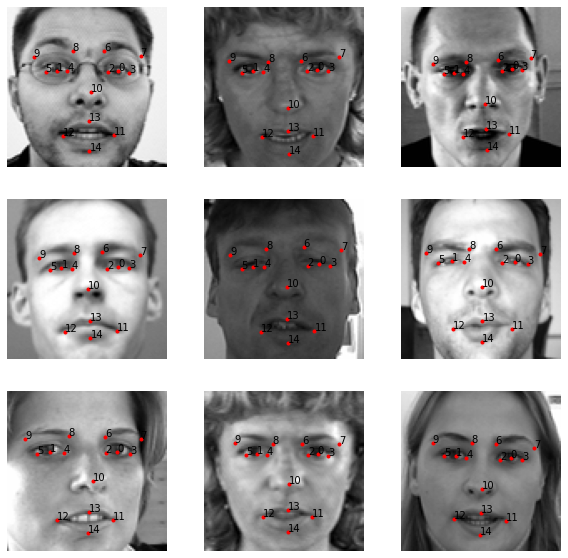

In [ ]:
test_keypoints_plot(images_list[:9], outputs_list[:9])